Alaska Airlines

In [183]:
import csv
import pandas as pd
import numpy as np
#import collections

#import xgboost as xgb

import matplotlib.pyplot as plt
import matplotlib.figure
%matplotlib inline


#from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from datetime import datetime
from datetime import timedelta
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

pd.set_option('display.max_columns', None)

## Preprocessing

In [437]:
df = pd.read_csv('flight_data_SAN.csv')
df.head()

,airline,flightno,origin,dest,totalseatcount,generalacft,depgate,arrgate,scheduled_departure_dttm,scheduled_arrival_dttm,actual_departure_dttm,actual_arrival_dttm,airtime,taxiout,taxiin,depvariance,arrvariance,internationalflag
0,AC,1886,SAN,YYZ,174,32S,034,F36,2018-01-01 11:40:00,2018-01-01 19:11:00,2018-01-01 13:03:00,2018-01-01 21:14:00,251.0,34.0,26.0,83.0,123.0,1
1,WN,6418,SAN,TUS,143,737,8,A3,2018-01-01 21:55:00,2018-01-02 00:10:00,2018-01-01 22:30:00,2018-01-02 00:36:00,50.0,12.0,4.0,35.0,26.0,0
2,AS,3456,SAN,STL,76,EMJ,18,C15,2018-01-01 09:40:00,2018-01-01 15:02:00,2018-01-01 09:37:00,2018-01-01 15:04:00,189.0,14.0,4.0,-3.0,2.0,0
3,WN,552,SAN,SMF,143,737,8,B15,2018-01-01 19:10:00,2018-01-01 20:45:00,2018-01-01 19:53:00,2018-01-01 21:19:00,67.0,15.0,4.0,43.0,34.0,0
4,WN,983,SAN,SMF,143,737,1A,B17,2018-01-01 15:05:00,2018-01-01 16:40:00,2018-01-01 15:15:00,2018-01-01 16:43:00,70.0,14.0,4.0,10.0,3.0,0


In [201]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188525 entries, 0 to 188524
Data columns (total 18 columns):
airline                     188525 non-null object
flightno                    188525 non-null int64
origin                      188525 non-null object
dest                        188525 non-null object
totalseatcount              188525 non-null int64
generalacft                 188363 non-null object
depgate                     185087 non-null object
arrgate                     182204 non-null object
scheduled_departure_dttm    188525 non-null object
scheduled_arrival_dttm      188525 non-null object
actual_departure_dttm       188212 non-null object
actual_arrival_dttm         188125 non-null object
airtime                     187259 non-null float64
taxiout                     187413 non-null float64
taxiin                      186931 non-null float64
depvariance                 188212 non-null float64
arrvariance                 188116 non-null float64
internationalflag  

In [438]:
#Dropped columns:  Information after wheels up 
df.drop(columns=['arrvariance', 'arrgate','arrvariance', 'scheduled_arrival_dttm', 'actual_arrival_dttm',
                 'taxiin', 'airtime','origin','depvariance'], inplace=True)

In [439]:
#Changing data type of departure and arrival times from object to datetime
df['actual_departure_dttm'] = [pd.to_datetime(x) for x in df['actual_departure_dttm']]
df['scheduled_departure_dttm'] = [pd.to_datetime(x) for x in df['scheduled_departure_dttm']]

In [205]:
df['actual_departure_dttm'].sort_values()

2321     2017-01-01 06:13:00
3132     2017-01-01 06:14:00
953      2017-01-01 06:14:00
2301     2017-01-01 06:15:00
2272     2017-01-01 06:15:00
2275     2017-01-01 06:15:00
3108     2017-01-01 06:21:00
159504   2017-01-01 06:25:00
3264     2017-01-01 06:27:00
3265     2017-01-01 06:27:00
3123     2017-01-01 06:29:00
1227     2017-01-01 06:33:00
2250     2017-01-01 06:36:00
2262     2017-01-01 06:38:00
1214     2017-01-01 06:40:00
2317     2017-01-01 06:46:00
2337     2017-01-01 06:47:00
2407     2017-01-01 06:54:00
2324     2017-01-01 06:55:00
3262     2017-01-01 06:57:00
2267     2017-01-01 06:57:00
3125     2017-01-01 07:00:00
2323     2017-01-01 07:15:00
957      2017-01-01 07:16:00
2261     2017-01-01 07:18:00
2325     2017-01-01 07:25:00
2319     2017-01-01 07:25:00
2396     2017-01-01 07:26:00
2249     2017-01-01 07:26:00
1226     2017-01-01 07:28:00
                 ...        
187474                   NaT
187479                   NaT
187502                   NaT
187522        

In [6]:
#We are going to use gate as a proxy for distance to runway. Need them as numbers 
df['depgate'].unique()

array(['034', '8', '18', '1A', '5', '17', '46', '15', '10', '11', '9',
       '42', '44', '41', '3', '49', '14', '7', '25', '23', '2', '47',
       '16', '4', '45', '32', '40', '38', '35', '28', '43', '39', '24',
       '33', '13', '51', '37', '1', '26', '36', '31', nan, '30', '27',
       '12', '6', '29', '34', '22', '50', '48', '036', '041', '043',
       '1286', 'Gate 18', 'Gate 15', 'Gate 16', 'Gate 11', 'Gate 13',
       'Gate 14', 'Gate 17', 'Gate 12', 'H30', '20', '21', '037', '16B',
       'C25', 'E18', 'B12', 'C2', 'A1', 'B4', 'C42', '11B', 'C4', 'B7',
       'C44', 'C3', 'B5', 'C11', 'A14', '2661', '038', '050', '76', '033',
       '956'], dtype=object)

In [440]:
#We need to get rid of any gate not between 1 and 51.  1A --> 0.1, Gate x --> x
df.replace('1A', 0.1,inplace=True)
df.replace("Gate 11", 11,inplace=True)
df.replace("Gate 12", 12,inplace=True)
df.replace("Gate 13", 13,inplace=True)
df.replace("Gate 14", 14,inplace=True)
df.replace("Gate 15", 15,inplace=True)
df.replace("Gate 16", 16,inplace=True)
df.replace("Gate 17", 17,inplace=True)
df.replace("Gate 18", 18,inplace=True)
df = df[~df['depgate'].isin (['1286','H30','16B', 'C25', 'E18', 'B12', 'C2', 'A1', 'B4','C42', '11B', 'C4', 'B7', 'C44', 'C3', 'B5', 'C11', 'A14', '2661', '76', '956'])]
df['depgate'] = pd.to_numeric(df['depgate'])

In [441]:
df['depgate'].value_counts()

5.0     6890
7.0     6757
6.0     6655
4.0     6500
2.0     6494
8.0     6486
3.0     6440
1.0     6353
9.0     6344
10.0    6311
11.0    4265
32.0    4174
38.0    4086
44.0    4085
14.0    4075
13.0    3965
42.0    3956
18.0    3929
17.0    3818
15.0    3800
45.0    3792
43.0    3725
0.1     3660
49.0    3637
16.0    3636
12.0    3394
33.0    3383
40.0    3332
39.0    3226
35.0    3190
29.0    3130
34.0    3075
41.0    3005
46.0    2959
27.0    2915
28.0    2798
37.0    2545
25.0    2524
47.0    2516
36.0    2363
26.0    2289
31.0    2268
48.0    2110
51.0    1733
30.0    1609
24.0    1589
50.0    1551
23.0    1525
22.0     801
21.0     454
20.0     326
Name: depgate, dtype: int64

In [442]:
df.shape

(187881, 10)

In [443]:
df.dropna(inplace=True)

In [444]:
df.shape

(183329, 10)

In [445]:
#Exploratory analysis in Tableau showed a taxiout value of 1039 (and also has a negative airtime) so we remove it
df = df[df['taxiout'] != 1039]

In [446]:
183328/188525

0.972433364275295

In [447]:
df.to_csv('alaska_cleaned.csv')

## Feature Selection

Research (https://www.aviationsystemsdivision.arc.nasa.gov/publications/2015/AIAA-2015-2272.pdf, 
https://pdfs.semanticscholar.org/cdcb/8f9380999147e162fbb4a67b9cfc889e8bc4.pdf)
has shown the following features should be considered: Gate, Spot, Runway, Aircraft model, Taxi distance from gate to runway, Number of departures on the surface by runway, and Number of arrivals on the surface by terminal.
We only have one runway (95% of the time) and we do not know the number of arrivals.
I will add in month, time of day, day of week as a proxy for spot/congestion


In [450]:
#Need to separate off month, day of week, and time of day from scheduled depart time
#Monday is 0 and Sunday is 6
df['year'] = df['scheduled_departure_dttm'].dt.year
#df['month'] = df['scheduled_departure_dttm'].dt.month
df['hour'] = df['scheduled_departure_dttm'].dt.hour
#df['dow'] = df['scheduled_departure_dttm'].dt.weekday

In [451]:
df = df[df['year']==2018]

In [453]:
dfm = df.drop(columns=['totalseatcount','year','airline','generalacft','internationalflag','dest','actual_departure_dttm','scheduled_departure_dttm','flightno'])      

In [454]:
dfm['hr6'] = np.where(dfm['hour']== 6, 1, 0)
dfm = dfm.drop(columns=['hour'])

In [455]:
dfm

,depgate,taxiout,hr6
0,34.0,34.0,0
1,8.0,12.0,0
2,18.0,14.0,0
3,8.0,15.0,0
4,0.1,14.0,0
5,5.0,11.0,0
6,17.0,26.0,1
7,46.0,25.0,0
8,15.0,28.0,0
9,5.0,8.0,0


In [510]:
#dfgb = dfm.groupby("depgate")["taxiout"].mean()
dfm.to_csv('alaska_2feature.csv')

In [264]:
#dfgb = pd.DataFrame(dfgb)
#dfgb = dfgb.reset_index()


In [456]:
dfgb = pd.DataFrame(dfm)
#dfgb = dfm.reset_index()

In [457]:
dfgb

,depgate,taxiout,hr6
0,34.0,34.0,0
1,8.0,12.0,0
2,18.0,14.0,0
3,8.0,15.0,0
4,0.1,14.0,0
5,5.0,11.0,0
6,17.0,26.0,1
7,46.0,25.0,0
8,15.0,28.0,0
9,5.0,8.0,0


In [312]:
dfgb.shape

(95447, 3)

In [393]:
#Need to create dummy variables for aircraft, month, day of week, depart time
#dfac= pd.get_dummies(df['generalacft'], prefix='aircraft')
#dfmonth = pd.get_dummies(df['month'], prefix='month')
#dfhour = pd.get_dummies(df['hour'], prefix='hour')
#dfdow = pd.get_dummies(df['dow'], prefix='dow')



In [398]:
#dfgb = pd.concat([dfm, dfhour, dfmonth, dfdow], axis=1, sort=False)

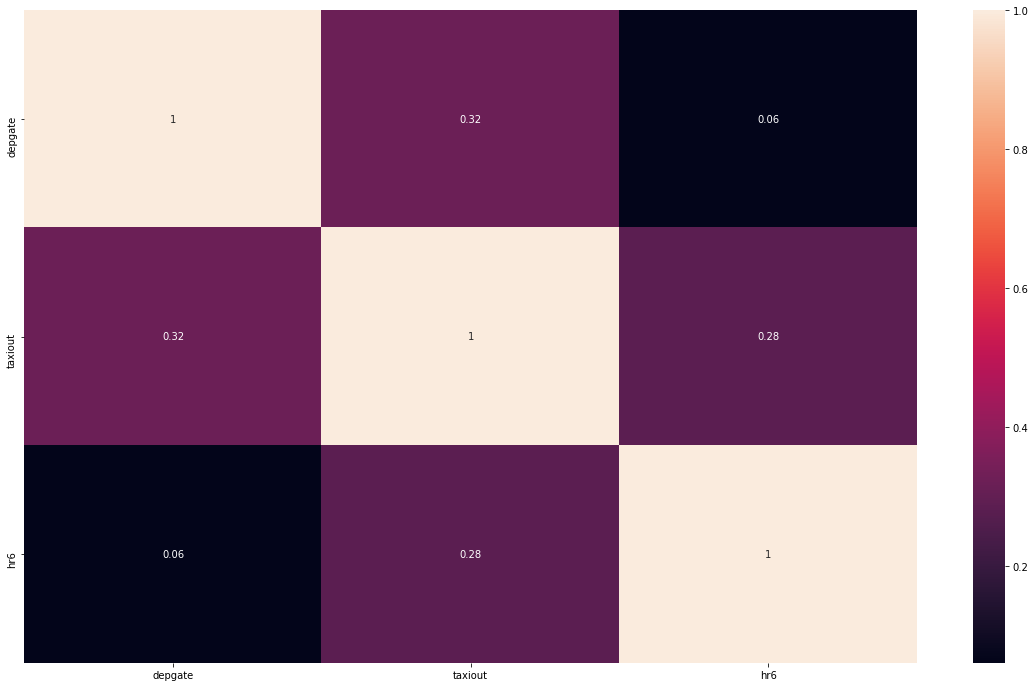

In [511]:
plt.figure(figsize=[20,12])
sns.heatmap(dfm.corr(), annot=True);

In [400]:
#dfgb = dfgb.drop(columns=['month', 'hour','dow'])      

In [529]:
dfin = dfm.drop(columns= ['taxiout','hr6'] )
dfout = dfm['taxiout']

In [530]:
X = pd.DataFrame(dfin)
y = pd.DataFrame(dfout)

In [531]:
X.head()

,depgate
0,34.0
1,8.0
2,18.0
3,8.0
4,0.1


In [532]:
X.shape, y.shape

((95447, 1), (95447, 1))

In [533]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .2, random_state=42)

In [534]:
X_test.shape, y_test.shape, X_train.shape, y_train.shape

((19090, 1), (19090, 1), (76357, 1), (76357, 1))

In [535]:
randomforest = RandomForestRegressor()
randomforest.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [536]:
table = list(zip(X,randomforest.feature_importances_))
dftable = pd.DataFrame(table, columns=['','Coef'])
dftable.sort_values(by='Coef', ascending=False)

,,Coef
0,depgate,1.0


In [537]:
scores = cross_val_score(randomforest, X_train, y_train, cv=10)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

In [538]:
scores

array([0.15774083, 0.16612909, 0.1553091 , 0.13824169, 0.14937346,
       0.15578342, 0.14120364, 0.15724098, 0.15631218, 0.13962949])

In [540]:
print(randomforest.score(X_train, y_train))
print(mean_squared_error(y_test, est.predict(X_test)))

0.15254958990401124
45.31490034864096


In [519]:
def rfr_model(X, y):
# Perform Grid-Search
    gsc = GridSearchCV(estimator=RandomForestRegressor(),param_grid={'max_depth': range(3,7), 'n_estimators': (10, 50, 100, 1000),  },
    cv=5, verbose=0, n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], random_state=False, verbose=False)
# Perform K-Fold CV
    scores = cross_val_score(rfr, X, y, cv=10)

    return scores

In [521]:
scores

array([0.2239645 , 0.24470132, 0.22649626, 0.21630011, 0.20852264,
       0.22775637, 0.20265229, 0.2354925 , 0.2267683 , 0.20361168])

## Modeling

In [8]:
# Setting new training and testing sets with new features
X = dfm
y = df['is_strike']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .2, random_state=42)


### Baseline

In [15]:
# Guessing all balls pitched are strikes
y_pred = y_test*0+1

print('F1 Score:', f1_score(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test,y_pred))

F1 Score: 0.7786285592406953
Accuracy: 0.6375034925956972


### Linear Regression

In [ ]:
No polynomials, logs, etc.

In [423]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print (lr.score(X_train, y_train))
print(mean_squared_error(y_test, lr.predict(X_test)))

0.17851780851887955
44.1104392881393


In [ ]:

print (lr.score(X_train, y_train))
print(mean_squared_error(y_test, lr.predict(X_test))

The degree 2 had an MSE of: 2.583275319755427
The degree 2 had an Rsquared of: 6.44228447574659


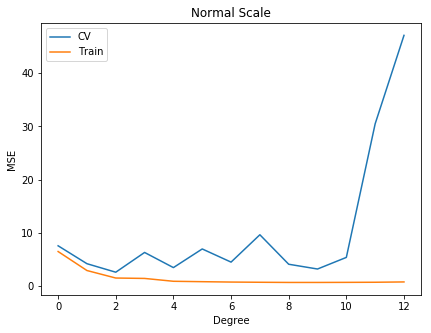

In [298]:
model = LinearRegression()
res_cv = {}
r2_cv = {}
res_train = {}
for degree in range(13):
    
    # transforms the data to polynomials
    poly = PolynomialFeatures(degree)
    X1 = poly.fit_transform(X)
    
    # calculates the MSE for CV
    scores = cross_val_score(model, X1, y, cv=10, scoring='neg_mean_squared_error') # cross val
    scoresr = cross_val_score(model, X1, y, cv=10, scoring='r2') 
    res_cv[degree] = np.mean(-scores)
    r2_cv[degree] = np.mean(-scoresr)
    
    # calculates the MSE for Training Set    
    model.fit(X1,y)
    y_pred = model.predict(X1)
    res_train[degree] = np.sum((y_pred-y)**2)/len(y)
    
degrees = list(res_cv.keys())
mse_cv = list(res_cv.values())
mse_train = list(res_train.values())
r2_cv = list(r2_cv.values())


plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
plt.plot(degrees,mse_cv)
plt.plot(degrees,mse_train)
plt.xlabel('Degree')
plt.ylabel('MSE')
plt.title('Normal Scale')
plt.legend(['CV','Train'])


loc = np.argmin(list(res_cv.values()))
print('The degree',degrees[loc],'had an MSE of:',mse_cv[loc])
print('The degree',degrees[loc],'had an Rsquared of:',r2_cv[loc])
#print('The degree',degrees[1],'had an MSE of:',mse_cv[1])
#print('The degree',degrees[1],'had an Rsquared of:',r2_cv[1])

In [539]:
# Adding degree 9 polynomial to Linear Regression
degree=9
est = make_pipeline(PolynomialFeatures(degree), StandardScaler(),LinearRegression())
est.fit(X_train, y_train)
print(est.score(X_train, y_train))
print(mean_squared_error(y_test, est.predict(X_test)))

0.14315353599875524
45.31490034864096


## Running Model on Test Data

In [10]:
dftest = pd.read_csv('2020-test.csv')

In [11]:
#Clean input test dataset
dftest.drop(columns=['is_strike'], inplace=True)
dfcut = dftest.drop(columns=['pitcher_id','pitcher_side','batter_id','batter_side','stadium_id', 'umpire_id', \
                             'catcher_id', 'top_bottom','tilt', 'pitch_type', 'y55', 'pitch_id'])
dfin = dfcut.loc[:,'inning']
dfnum = dfcut.loc[:,'outs':'z55']
dfm = pd.concat([dfin, dfnum], axis=1, sort=False)

#Filling in NAs with mean of column
dfm.fillna(dfm.mean(),inplace=True)

#scaler = StandardScaler()
#Xt = scaler.transform(dfm)

In [474]:
y_pred.shape,est.predict(X_test).shape

((51, 1), (19090, 1))

## Results QC

ValueError: x and y must be the same size

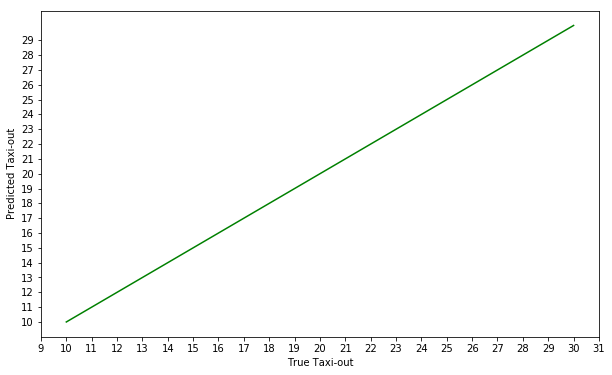

In [509]:
plt.figure(figsize=[10,6])
#a = plt.scatter(y_test,est.predict(X_test), c = 'blue')
plt.xticks(np.arange(0, 120, 1))
plt.yticks(np.arange(10, 30, 1))
plt.ylabel('Predicted Taxi-out')
plt.xlabel('True Taxi-out')

#Perfect fit
b = plt.plot([10,30],[10,30], c = 'green')
ypred=est.predict(X_test)
ymean = y_test.mean()

c = plt.scatter(ymean,est.predict(X_test), c = 'red')
#Baseline: Average Review in Training Data Set
#Xb = y_test*0+14
# plt.plot([3.7563829787234027,3.7563829787234027],[1.5,5], color = 'orange')
# c = plt.scatter(Xb,y_test,c = 'orange' )

#legend = ax.legend(loc='upper center', shadow=True)
plt.legend(('Perfect Fit','True v Predicted', 'Average Taxi-out Rating (Baseline)'),loc= 'best')
plt.title('Predicted Taxi-out vs True Taxi-out')

In [507]:
y_test

,taxiout
183836,20.0
79840,15.0
174910,20.0
91646,12.0
113406,18.0
129720,14.0
73471,12.0
118254,14.0
176066,14.0
178537,12.0
